# Pepperdine Trading Capital Code

In [5]:
# Imports
import os
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from pandas.tseries.offsets import DateOffset
from finta import TA
import numpy as np
import hvplot.pandas
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [6]:
# Load .env environment variables
env_path = Path("./alpaca_keys.env")
load_dotenv(dotenv_path=env_path)

Python-dotenv could not parse statement starting at line 1


True

##### Connect to Alpaca API and import data

In [7]:
# Create API variables
API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"

In [8]:
# Create a connection to the API 
alpaca = tradeapi.REST(
    API_KEY,
    API_SECRET,
    ALPACA_API_BASE_URL,
    api_version="v2")

In [9]:
# Set the Bitcoin ticker
btc_ticker = ["BTCUSD"]

In [10]:
# Set the timestamp parameter tz to "America/New_York", 
start_date = pd.Timestamp("2015-11-20", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-02-08", tz="America/New_York").isoformat()

In [11]:
# Set timeframe to one day (1D) for the Alpaca API
timeframe = "1Day"

##### Preprocess Bitcoin Data

In [12]:
# Use the Alpaca get_crypto_bars function to gather the price information for BITCOIN
btc_data_df = alpaca.get_crypto_bars(
    btc_ticker,
    timeframe,
    start = start_date,
    end = end_date,
    exchanges = 'CBSE'
).df

# Review the DataFrame
display(btc_data_df.head())
display(btc_data_df.tail())

,exchange,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,,
2015-11-20 06:00:00+00:00,CBSE,322.39,324.99,316.33,324.99,2042.537728,2909,320.372700,BTCUSD
2015-11-21 06:00:00+00:00,CBSE,324.99,328.00,323.20,327.00,3083.421081,6219,325.926716,BTCUSD
2015-11-22 06:00:00+00:00,CBSE,323.72,324.17,322.48,322.78,1109.903368,1768,323.190987,BTCUSD
2015-11-23 06:00:00+00:00,CBSE,323.01,323.01,318.00,321.75,1349.480044,1807,320.906397,BTCUSD
2015-11-24 06:00:00+00:00,CBSE,320.96,321.23,316.26,318.85,1769.107382,2876,318.811281,BTCUSD


,exchange,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,,
2022-02-03 06:00:00+00:00,CBSE,37019.85,37716.88,36259.01,37566.75,12950.951771,466412,36815.486865,BTCUSD
2022-02-04 06:00:00+00:00,CBSE,37568.90,41970.00,37318.00,41557.54,24502.567312,671826,39904.715624,BTCUSD
2022-02-05 06:00:00+00:00,CBSE,41559.01,41934.38,40955.40,41610.64,8115.040087,363293,41523.705514,BTCUSD
2022-02-06 06:00:00+00:00,CBSE,41610.65,43036.87,41135.39,42835.99,11326.596609,397149,42135.642534,BTCUSD
2022-02-07 06:00:00+00:00,CBSE,42835.26,45035.00,42258.61,44916.93,17605.802688,636403,43757.460174,BTCUSD


In [13]:
# Create a new dataframe in OHLCV format
btc_prices_df = btc_data_df.drop(columns = ['exchange', 'trade_count', 'vwap', 'symbol'])

# Change the index to datetime format
btc_prices_df.index =btc_prices_df.index.date

# Review the DataFrame
display(btc_prices_df.head(5))

,open,high,low,close,volume
2015-11-20,322.39,324.99,316.33,324.99,2042.537728
2015-11-21,324.99,328.00,323.20,327.00,3083.421081
2015-11-22,323.72,324.17,322.48,322.78,1109.903368
2015-11-23,323.01,323.01,318.00,321.75,1349.480044
2015-11-24,320.96,321.23,316.26,318.85,1769.107382


### The "HODL Strategy" gains

In [14]:
# Define the start and end date for the HODL strategy
startdate_hodl =  pd.to_datetime("2016-12-24").date()
enddate_hodl = pd.to_datetime("2022-02-08").date()

In [15]:
# Create the HODL strategy dataframe 
btc_prices_hodl = btc_prices_df.loc[startdate_hodl:enddate_hodl].copy()

# Add the Actual returns column to indicate daily percentage change in closing price
btc_prices_hodl["Actual Returns"] = btc_prices_hodl["close"].pct_change()

# Drop null values
btc_prices_hodl=btc_prices_hodl.dropna()

# Review the DataFrame
btc_prices_hodl.head()

,open,high,low,close,volume,Actual Returns
2016-12-25,876.45,897.40,851.11,896.12,3439.397208,0.022431
2016-12-26,902.08,903.00,895.00,898.95,855.589004,0.003158
2016-12-27,925.28,948.99,923.95,942.73,2319.854766,0.048701
2016-12-28,982.25,988.88,970.76,981.91,2850.629363,0.041560
2016-12-29,970.51,970.51,949.00,950.49,2030.405944,-0.031999


In [16]:
# Calculate the cumulative returns of the HODL Strategy
cum_returns_hodl = (1 + btc_prices_hodl["Actual Returns"]).cumprod()

# Review the Results
cum_returns_hodl[-1]

51.248123131688736

In [17]:
# Use the describe function to calulate the daily standard deviation
btc_prices_hodl["Actual Returns"].describe()['std']

0.04403474301384851

## PTC team standard investment approaches

#### 5 Day SMA crossing the 23 day SMA

In [18]:
# Define the start and end date for the 5 day and 23 day SMA strategy
startdate_sma523 =  pd.to_datetime("2016-12-03").date()
enddate_sma523 = pd.to_datetime("2022-02-08").date()

In [19]:
# Create the 5 day and 23 day SMA strategy dataframe 
btc_prices_sma523 = btc_prices_df.loc[startdate_sma523:enddate_sma523].copy()

In [20]:
# Use finta library to create the 5 day SMA and 23 day SMA columns
btc_prices_sma523["sma5"] = TA.SMA(btc_prices_sma523, 5) 
btc_prices_sma523["sma23"] = TA.SMA(btc_prices_sma523, 23) 

# Add the Actual Returns column to indicate daily percentage change in closing price
btc_prices_sma523["Actual Returns"] = btc_prices_sma523["close"].pct_change()

In [21]:
# Create a new dataframe that drops the OHLCV columns
btc_signals_sma523 = btc_prices_sma523.drop(columns = ['close','open', 'high', 'low','volume'])

# Drop null values
btc_signals_sma523= btc_signals_sma523.dropna()

# Generate the predictions columns using 0 or 1, where 1 indicates that sma5 is greater than the sma23 and 0 is when the condition is not met
btc_signals_sma523["sma523_pred"] = np.where(
    btc_signals_sma523["sma5"]> btc_signals_sma523["sma23"], 1.0, 0.0
)

# Review the DataFrame
display(btc_signals_sma523.head())

,sma5,sma23,Actual Returns,sma523_pred
2016-12-25,884.928,799.247391,0.022431,1.0
2016-12-26,895.534,804.982174,0.003158,1.0
2016-12-27,905.382,813.150435,0.048701,1.0
2016-12-28,919.234,822.989565,0.041560,1.0
2016-12-29,934.040,831.280435,-0.031999,1.0


In [22]:
# Calculate the cumulative returns of the HODL Strategy
sma523_strategy_returns = (1 + btc_signals_sma523["sma523_pred"] * btc_signals_sma523["Actual Returns"]).cumprod()

# Review the Results
sma523_strategy_returns[-1]

256.9830249102026

In [23]:
# Use the describe function to calulate the daily standard deviation
btc_prices_sma523["Actual Returns"].describe()['std']

0.04383798888046262

In [24]:
# Create a signal column for ML trading strategy 1
btc_signals_sma523['signal'] = (btc_signals_sma523["Actual Returns"] > 0).astype(int).copy()

#### 20 Day SMA crossing the 50 Day SMA

In [25]:
# Define the start and end date for the 20 day and 50 day SMA strategy
startdate_sma2050 =  pd.to_datetime("2016-11-06").date()
enddate_sma2050 = pd.to_datetime("2022-02-08").date()

In [26]:
# Create the 20 day and 50 day SMA strategy dataframe 
btc_prices_sma2050 = btc_prices_df.loc[startdate_sma2050:enddate_sma2050].copy()

In [27]:
# Use finta library to create the 20 day SMA and 50 day SMA columns
btc_prices_sma2050["sma20"] = TA.SMA(btc_prices_sma2050, 20) 
btc_prices_sma2050["sma50"] = TA.SMA(btc_prices_sma2050, 50) 

# Add the Actual Returns column to indicate daily percentage change in closing price
btc_prices_sma2050["Actual Returns"] = btc_prices_sma2050["close"].pct_change()

In [28]:
# Create a new dataframe that drops the OHLCV columns
btc_signals_sma2050 = btc_prices_sma2050.drop(columns = ['close','open', 'high', 'low','volume'])

# Drop null values
btc_signals_sma2050= btc_signals_sma2050.dropna()

# Generate the predictions columns using 0 or 1, where 1 indicates that sma20 is greater than the sma50 and 0 is when the condition is not met
btc_signals_sma2050["sma2050_pred"] = np.where(
    btc_signals_sma2050["sma20"]> btc_signals_sma2050["sma50"], 1.0, 0.0
)

# Review the DataFrame
display(btc_signals_sma2050.head())

,sma20,sma50,Actual Returns,sma2050_pred
2016-12-25,805.2585,762.2482,0.022431,1.0
2016-12-26,812.2160,766.0236,0.003158,1.0
2016-12-27,821.1180,770.7312,0.048701,1.0
2016-12-28,831.7875,775.4696,0.041560,1.0
2016-12-29,840.6940,780.1254,-0.031999,1.0


In [29]:
# Calculate the cumulative returns of the the 20 day and 50 day SMA strategy
sma2050_strategy_returns = (1 + btc_signals_sma2050["sma2050_pred"] * btc_signals_sma2050["Actual Returns"]).cumprod()

# Review the Results
sma2050_strategy_returns[-1]

57.33127099443229

In [30]:
# Use the describe function to calulate the daily standard deviation
btc_prices_sma2050["Actual Returns"].describe()['std']

0.043575387300434365

In [31]:
# Create a signal column for ML trading strategy 2
btc_signals_sma2050['signal'] = (btc_signals_sma2050["Actual Returns"] > 0).astype(int).copy()

#### 200 Day SMA crossing the 400 Day SMA

In [32]:
# Define the start and end date for the 200 day and 400 day SMA strategy
startdate_sma200400 =  pd.to_datetime("2015-11-22").date()
enddate_sma200400 = pd.to_datetime("2022-02-08").date()

In [33]:
# Create the 200 day and 400 day SMA strategy dataframe 
btc_prices_sma200400 = btc_prices_df.loc[startdate_sma200400:enddate_sma200400].copy()

In [34]:
# Use finta library to create the 200 day SMA and 400 day SMA columns
btc_prices_sma200400["sma200"] = TA.SMA(btc_prices_sma200400, 200) 
btc_prices_sma200400["sma400"] = TA.SMA(btc_prices_sma200400, 400) 

# Add the Actual Returns column to indicate daily percentage change in closing price
btc_prices_sma200400["Actual Returns"] = btc_prices_sma200400["close"].pct_change()

In [35]:
# Create a new dataframe that drops the OHLCV columns
btc_signals_sma200400 = btc_prices_sma200400.drop(columns = ['close','open', 'high', 'low','volume'])

# Drop null values
btc_signals_sma200400= btc_signals_sma200400.dropna()

# Generate the predictions columns using 0 or 1, where 1 indicates that sma200 is greater than the sma400 and 0 is when the condition is not met
btc_signals_sma200400["sma200400_pred"] = np.where(
    btc_signals_sma200400["sma200"]> btc_signals_sma200400["sma400"], 1.0, 0.0
)

# Review the DataFrame
display(btc_signals_sma200400.head())

,sma200,sma400,Actual Returns,sma200400_pred
2016-12-25,666.24325,547.066650,0.022431,1.0
2016-12-26,667.85070,548.507075,0.003158,1.0
2016-12-27,669.63585,550.059525,0.048701,1.0
2016-12-28,671.36040,551.717175,0.041560,1.0
2016-12-29,672.72355,553.262675,-0.031999,1.0


In [36]:
# Calculate the cumulative returns of the the 200 day and 400 day SMA strategy
sma200400_strategy_returns = (1 + btc_signals_sma200400["sma200400_pred"] * btc_signals_sma200400["Actual Returns"]).cumprod()

# Review the Results
sma200400_strategy_returns[-1]

20.09519645576306

In [37]:
# Use the describe function to calulate the daily standard deviation
btc_prices_sma200400["Actual Returns"].describe()['std']

0.04144709580087043

In [38]:
# Create a signal column for ML trading strategy 3
btc_signals_sma200400['signal'] = (btc_signals_sma200400["Actual Returns"] > 0).astype(int).copy()

#### 8 Day EMA crossing the 34 Day EMA

In [39]:
# Define the start and end date for the 8 day and 34 day EMA strategy
startdate_ema834 =  pd.to_datetime("2016-12-24").date()
enddate_ema834 = pd.to_datetime("2022-02-08").date()

In [40]:
# Create the 8 day and 34 day EMA strategy dataframe 
btc_prices_ema834 = btc_prices_df.loc[startdate_ema834:enddate_ema834].copy()

In [41]:
# Use finta library to create the 8 day EMA and 34 day EMA columns
btc_prices_ema834["ema8"] = TA.EMA(btc_prices_ema834, 8) 
btc_prices_ema834["ema34"] = TA.EMA(btc_prices_ema834, 34) 

# Add the Actual Returns column to indicate daily percentage change in closing price
btc_prices_ema834["Actual Returns"] = btc_prices_ema834["close"].pct_change()

In [42]:
# Create a new dataframe that drops the OHLCV columns
btc_signals_ema834 = btc_prices_ema834.drop(columns = ['close','open', 'high', 'low','volume'])

# Drop null values
btc_signals_ema834= btc_signals_ema834.dropna()

# Generate the predictions columns using 0 or 1, where 1 indicates that sma20 is greater than the sma50 and 0 is when the condition is not met
btc_signals_ema834["ema_pred"] = np.where(
    btc_signals_ema834["ema8"]> btc_signals_ema834["ema34"], 1.0, 0.0
)

# Review the DataFrame
display(btc_signals_ema834.head())

,ema8,ema34,Actual Returns,ema_pred
2016-12-25,887.518750,886.579118,0.022431,1.0
2016-12-26,892.316321,890.947619,0.003158,1.0
2016-12-27,909.985346,905.057192,0.048701,1.0
2016-12-28,932.327927,922.287596,0.041560,1.0
2016-12-29,937.511460,927.705480,-0.031999,1.0


In [43]:
# Calculate the cumulative returns of the 8 day and 34 day EMA strategy
ema834_strategy_returns = (1 + btc_signals_ema834["ema_pred"] * btc_signals_ema834["Actual Returns"]).cumprod()

# Review the Results
ema834_strategy_returns[-1]

311.37937401598526

In [44]:
# Use the describe function to calulate the daily standard deviation
btc_prices_ema834["Actual Returns"].describe()['std']

0.04403474301384851

In [45]:
# Create a signal column for ML trading strategy 4
btc_signals_ema834['signal'] = (btc_signals_ema834["Actual Returns"] > 0).astype(int).copy()

# PTC ML Trading Strategies

#### Create Training and Testing Period (Train with 75% of data and use remaining 25% as test data)

In [46]:
# Define the start and end date of the training periods 
training_startdate = pd.to_datetime("2016-12-24").date()
training_enddate = pd.to_datetime( "2020-09-08").date()

testing_startdate = pd.to_datetime("2020-09-09").date()
testing_enddate = pd.to_datetime( "2022-02-08").date()


## ML Trading Strategy 1

In [47]:
# Create the features dataframe 
btc_model1_features = btc_signals_sma523.drop(columns = ['signal','sma523_pred'])

In [48]:
# Add a columnn for the target variable
btc_model1_features['y'] = btc_signals_sma523['signal'].shift(-1)

# Drop null values
btc_model1_features = btc_model1_features.dropna()

# Review the DataFrame
btc_model1_features.head()

,sma5,sma23,Actual Returns,y
2016-12-25,884.928,799.247391,0.022431,1.0
2016-12-26,895.534,804.982174,0.003158,1.0
2016-12-27,905.382,813.150435,0.048701,1.0
2016-12-28,919.234,822.989565,0.041560,0.0
2016-12-29,934.040,831.280435,-0.031999,1.0


In [49]:
# Create the target set by slicing the y column
y = btc_model1_features['y']

# Assign a copy of the bitcoin model features DataFrame called X1
X1 = btc_model1_features.drop(columns = ['y', "Actual Returns"])

In [50]:
# Generate the X1_train and y_train DataFrames
X1_train = X1.loc[training_startdate:training_enddate]
y_train = y.loc[training_startdate:training_enddate]

# Generate the X1_test and y_test DataFrames
X1_test = X1.loc[testing_startdate:testing_enddate]
y_test = y.loc[testing_startdate:testing_enddate]

# Review the X1_test and train DataFrame
display(X1_train.head(5))
display(X1_test.tail(5))

,sma5,sma23
2016-12-25,884.928,799.247391
2016-12-26,895.534,804.982174
2016-12-27,905.382,813.150435
2016-12-28,919.234,822.989565
2016-12-29,934.040,831.280435


,sma5,sma23
2022-02-02,37820.182,39254.563043
2022-02-03,37703.846,39030.328261
2022-02-04,38610.064,38937.684783
2022-02-05,39236.788,38881.216087
2022-02-06,40118.152,38873.933478


In [51]:
# Standardize the Data

# Create a StandardScaler instance
scaler1 = StandardScaler()

# Apply the scaler model to fit the X1_train data
X1_scaler = scaler1.fit(X1_train)

# Transform the X1_train and X1_test DataFrames using the X1_scaler
X1_train_scaled = X1_scaler.transform(X1_train)
X1_test_scaled = X1_scaler.transform(X1_test)

In [52]:
# From SVM, instantiate SVC classifier model instance
svm_model1 = svm.SVC()
 
# Fit the model to the data using the training data
svm_model1 = svm_model1.fit(X1_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred1 = svm_model1.predict(X1_test_scaled)

# Review the model's predicted values
svm_pred1[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [53]:
# Use a classification report to evaluate the model using the predictions and testing data
SVM1_testing_report = classification_report(y_test, svm_pred1)

# Print the classification report
print(SVM1_testing_report)


              precision    recall  f1-score   support

         0.0       0.38      0.06      0.11       238
         1.0       0.53      0.91      0.67       278

    accuracy                           0.52       516
   macro avg       0.46      0.49      0.39       516
weighted avg       0.46      0.52      0.41       516



In [54]:
# Create a predictions DataFrame
btc1_predictions_df = pd.DataFrame(index=X1_test.index)

# Add the SVM model predictions to the DataFrame
btc1_predictions_df['Predicted'] = svm_pred1

# Add the label test data to the bitcoin predictions df
btc1_predictions_df['y_test'] = y_test

# Add the actual returns to the DataFrame
btc1_predictions_df['Actual Returns'] =  btc_signals_sma523["Actual Returns"]

# Shift the labeled test data back to its original date
btc1_predictions_df['y_test'] = btc1_predictions_df['y_test'].shift(1).dropna()

# Add the strategy returns to the DataFrame
btc1_predictions_df['Strategy Returns'] = btc1_predictions_df['Predicted'] * btc1_predictions_df['Actual Returns']

# Review the DataFrame
display(btc1_predictions_df.head(5))
display(btc1_predictions_df.tail(5))

,Predicted,y_test,Actual Returns,Strategy Returns
2020-09-09,1.0,NaN,0.009764,0.009764
2020-09-10,1.0,1.0,0.011606,0.011606
2020-09-11,1.0,1.0,0.001985,0.001985
2020-09-12,1.0,1.0,0.007986,0.007986
2020-09-13,1.0,0.0,-0.009307,-0.009307


,Predicted,y_test,Actual Returns,Strategy Returns
2022-02-02,1.0,0.0,-0.036673,-0.036673
2022-02-03,1.0,1.0,0.014773,0.014773
2022-02-04,1.0,1.0,0.106232,0.106232
2022-02-05,1.0,1.0,0.001278,0.001278
2022-02-06,1.0,1.0,0.029448,0.029448


<AxesSubplot:title={'center':'actual returns vs. ML Trading Strategy 1'}>

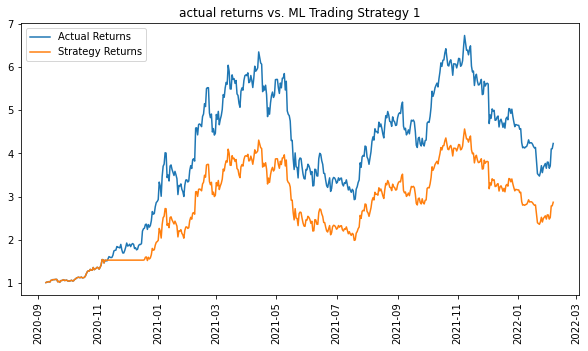

In [55]:
# Plot the actual returns versus the strategy returns
(1 + btc1_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    title = 'actual returns vs. ML Trading Strategy 1',
    rot = 90,
    figsize = (10,5)
)

In [56]:
# Calculate the cumulative returns of the ML Trading Strategy 1
mlstrat1_returns = (1 + btc1_predictions_df["Strategy Returns"]).cumprod()

# Review the Results
mlstrat1_returns[-1]

2.8697428541907533

In [57]:
# Use the describe function to calulate the daily standard deviation
btc1_predictions_df["Strategy Returns"].describe()['std']

0.03901741625138366

## ML Trading Strategy 2

In [58]:
# Create the features dataframe 
btc_model2_features = btc_signals_sma2050.drop(columns = ['signal','sma2050_pred'])

In [59]:
#Add Columnn for the target variable
btc_model2_features['y'] = btc_signals_sma2050['signal'].shift(-1)

# Drop null values
btc_model2_features = btc_model2_features.dropna()

# Review the DataFrame
btc_model2_features.head()

,sma20,sma50,Actual Returns,y
2016-12-25,805.2585,762.2482,0.022431,1.0
2016-12-26,812.2160,766.0236,0.003158,1.0
2016-12-27,821.1180,770.7312,0.048701,1.0
2016-12-28,831.7875,775.4696,0.041560,0.0
2016-12-29,840.6940,780.1254,-0.031999,1.0


In [60]:
# Create the target set by slicing the y column
y = btc_model2_features['y']

# Assign a copy of the bitcoin model features DataFrame called X2
X2 = btc_model2_features.drop(columns = ['y', "Actual Returns"])

In [61]:
# Generate the X2_train and y_train DataFrames
X2_train = X2.loc[training_startdate:training_enddate]
y_train = y.loc[training_startdate:training_enddate]

# Generate the X2_test and y_test DataFrames
X2_test = X2.loc[testing_startdate:testing_enddate]
y_test = y.loc[testing_startdate:testing_enddate]

# Review the X2_test and train DataFrame
display(X2_train.head(5))
display(X2_test.tail(5))

,sma20,sma50
2016-12-25,805.2585,762.2482
2016-12-26,812.2160,766.0236
2016-12-27,821.1180,770.7312
2016-12-28,831.7875,775.4696
2016-12-29,840.6940,780.1254


,sma20,sma50
2022-02-02,38676.652,43326.2020
2022-02-03,38404.815,43107.0402
2022-02-04,38332.989,42983.7352
2022-02-05,38280.020,42883.5732
2022-02-06,38315.532,42787.7942


In [62]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler2 = StandardScaler()

# Apply the scaler model to fit the X2_train data
X2_scaler = scaler2.fit(X2_train)

# Transform the X2_train and X2_test DataFrames using the X_scaler
X2_train_scaled = X2_scaler.transform(X2_train)
X2_test_scaled = X2_scaler.transform(X2_test)

In [63]:
# From SVM, instantiate SVC classifier model instance
svm_model2 = svm.SVC()
 
# Fit the model to the data using the training data
svm_model2 = svm_model2.fit(X2_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred2 = svm_model2.predict(X2_test_scaled)

# Review the model's predicted values
svm_pred2[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [64]:
# Use a classification report to evaluate the model using the predictions and testing data
SVM2_testing_report = classification_report(y_test, svm_pred2)

# Print the classification report
print(SVM2_testing_report)


              precision    recall  f1-score   support

         0.0       0.39      0.05      0.10       238
         1.0       0.53      0.93      0.68       278

    accuracy                           0.53       516
   macro avg       0.46      0.49      0.39       516
weighted avg       0.47      0.53      0.41       516



In [65]:
# Create a predictions DataFrame
btc2_predictions_df = pd.DataFrame(index=X2_test.index)

# Add the SVM model predictions to the DataFrame
btc2_predictions_df['Predicted'] = svm_pred2

# Add the label test data to the bitcoin predictions df
btc2_predictions_df['y_test'] = y_test

# Add the actual returns to the DataFrame
btc2_predictions_df['Actual Returns'] =  btc_signals_sma2050["Actual Returns"]

# Shift the labeled test data back to its original date
btc2_predictions_df['y_test'] = btc2_predictions_df['y_test'].shift(1).dropna()

# Add the strategy returns to the DataFrame
btc2_predictions_df['Strategy Returns'] = btc2_predictions_df['Predicted'] * btc2_predictions_df['Actual Returns']

# Review the DataFrame
display(btc2_predictions_df.head(5))
display(btc2_predictions_df.tail(5))

,Predicted,y_test,Actual Returns,Strategy Returns
2020-09-09,1.0,NaN,0.009764,0.009764
2020-09-10,1.0,1.0,0.011606,0.011606
2020-09-11,1.0,1.0,0.001985,0.001985
2020-09-12,1.0,1.0,0.007986,0.007986
2020-09-13,1.0,0.0,-0.009307,-0.009307


,Predicted,y_test,Actual Returns,Strategy Returns
2022-02-02,1.0,0.0,-0.036673,-0.036673
2022-02-03,1.0,1.0,0.014773,0.014773
2022-02-04,1.0,1.0,0.106232,0.106232
2022-02-05,1.0,1.0,0.001278,0.001278
2022-02-06,1.0,1.0,0.029448,0.029448


<AxesSubplot:title={'center':'Actual returns vs. ML Trading Strategy 2'}>

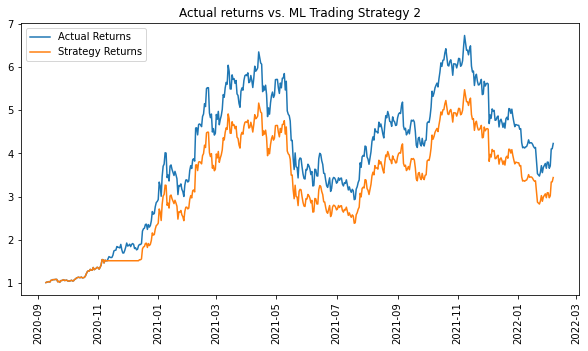

In [66]:
# Plot the actual returns versus the strategy returns
(1 + btc2_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    title = 'Actual returns vs. ML Trading Strategy 2',
    rot = 90,
    figsize = (10,5)
)

In [67]:
# Calculate the cumulative returns of the ML Trading Strategy 2
mlstrat2_returns = (1 + btc2_predictions_df["Strategy Returns"]).cumprod()

# Review the Results
mlstrat2_returns[-1]

3.4411597722691694

In [68]:
# Use the describe function to calulate the daily standard deviation
btc2_predictions_df["Strategy Returns"].describe()['std']

0.039574800416207485

## ML Trading Strategy 3

In [69]:
# Create the features dataframe 
btc_model3_features = btc_signals_sma200400.drop(columns = ['signal','sma200400_pred'])

In [70]:
#Add Columnn for the target variable
btc_model3_features['y'] = btc_signals_sma200400['signal'].shift(-1)

# Drop null values
btc_model3_features = btc_model3_features.dropna()

# Review the DataFrame
btc_model3_features.head()

,sma200,sma400,Actual Returns,y
2016-12-25,666.24325,547.066650,0.022431,1.0
2016-12-26,667.85070,548.507075,0.003158,1.0
2016-12-27,669.63585,550.059525,0.048701,1.0
2016-12-28,671.36040,551.717175,0.041560,0.0
2016-12-29,672.72355,553.262675,-0.031999,1.0


In [71]:
# Create the target set by slicing the y column
y = btc_model3_features['y']

# Assign a copy of the bitcoin model features DataFrame called X3
X3 = btc_model3_features.drop(columns = ['y', "Actual Returns"])

In [72]:
# Generate the X3_train and y_train DataFrames
X3_train = X3.loc[training_startdate:training_enddate]
y_train = y.loc[training_startdate:training_enddate]

# Generate the X3_test and y_test DataFrames
X3_test = X3.loc[testing_startdate:testing_enddate]
y_test = y.loc[testing_startdate:testing_enddate]

# Review the X3_train and test DataFrame
display(X3_train.head(5))
display(X3_test.tail(5))

,sma200,sma400
2016-12-25,666.24325,547.066650
2016-12-26,667.85070,548.507075
2016-12-27,669.63585,550.059525
2016-12-28,671.36040,551.717175
2016-12-29,672.72355,553.262675


,sma200,sma400
2022-02-02,48927.15005,46706.045375
2022-02-03,48956.24665,46727.492250
2022-02-04,49015.72280,46758.284125
2022-02-05,49074.79520,46788.103150
2022-02-06,49128.29920,46810.744425


In [73]:
# Standardize the Data

# Create a StandardScaler instance
scaler3 = StandardScaler()

# Apply the scaler model to fit the X3_train data
X3_scaler = scaler3.fit(X3_train)

# Transform the X3_train and X3_test DataFrames using the X3_scaler
X3_train_scaled = X3_scaler.transform(X3_train)
X3_test_scaled = X3_scaler.transform(X3_test)

In [74]:
# From SVM, instantiate SVC classifier model instance
svm_model3 = svm.SVC()
 
# Fit the model to the data using the training data
svm_model3 = svm_model3.fit(X3_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred3 = svm_model3.predict(X3_test_scaled)

# Review the model's predicted values
svm_pred3[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [75]:
# Use a classification report to evaluate the model using the predictions and testing data
SVM3_testing_report = classification_report(y_test, svm_pred3)

# Print the classification report
print(SVM3_testing_report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       238
         1.0       0.54      1.00      0.70       278

    accuracy                           0.54       516
   macro avg       0.27      0.50      0.35       516
weighted avg       0.29      0.54      0.38       516



C:\Users\thaye\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thaye\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thaye\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
# Create a predictions DataFrame
btc3_predictions_df = pd.DataFrame(index=X3_test.index)

# Add the SVM model predictions to the DataFrame
btc3_predictions_df['Predicted'] = svm_pred3

# Add the label test data to the bitcoin predictions df
btc3_predictions_df['y_test'] = y_test

# Add the actual returns to the DataFrame
btc3_predictions_df['Actual Returns'] =  btc_signals_sma200400["Actual Returns"]

# Shift the labeled test data back to its original date
btc3_predictions_df['y_test'] = btc3_predictions_df['y_test'].shift(1).dropna()

# Add the strategy returns to the DataFrame
btc3_predictions_df['Strategy Returns'] = btc3_predictions_df['Predicted'] * btc3_predictions_df['Actual Returns']

# Review the DataFrame
display(btc3_predictions_df.head(5))
display(btc3_predictions_df.tail(5))

,Predicted,y_test,Actual Returns,Strategy Returns
2020-09-09,1.0,NaN,0.009764,0.009764
2020-09-10,1.0,1.0,0.011606,0.011606
2020-09-11,1.0,1.0,0.001985,0.001985
2020-09-12,1.0,1.0,0.007986,0.007986
2020-09-13,1.0,0.0,-0.009307,-0.009307


,Predicted,y_test,Actual Returns,Strategy Returns
2022-02-02,1.0,0.0,-0.036673,-0.036673
2022-02-03,1.0,1.0,0.014773,0.014773
2022-02-04,1.0,1.0,0.106232,0.106232
2022-02-05,1.0,1.0,0.001278,0.001278
2022-02-06,1.0,1.0,0.029448,0.029448


<AxesSubplot:title={'center':'actual returns vs. ML Trading Strategy 3'}>

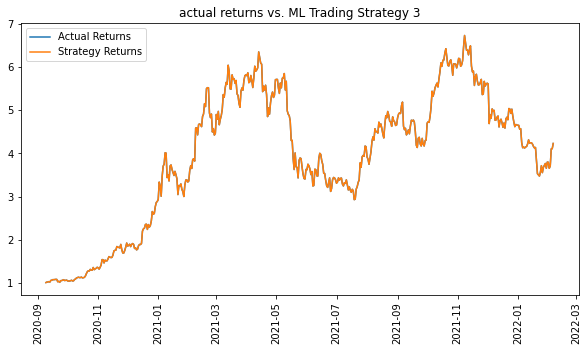

In [77]:
# Plot the actual returns versus the strategy returns
(1 + btc3_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    title = 'actual returns vs. ML Trading Strategy 3',
    rot = 90,
    figsize = (10,5)
)

In [78]:
# Calculate the cumulative returns of the ML Trading Strategy 3
mlstrat3_returns = (1 + btc3_predictions_df["Strategy Returns"]).cumprod()

# Review the Results
mlstrat3_returns[-1]

4.230426765978409

In [79]:
# Use the describe function to calulate the daily standard deviation
btc3_predictions_df["Strategy Returns"].describe()['std']

0.040315624533539415

## ML Trading Strategy 4

In [80]:
# Create the features dataframe 
btc_model4_features = btc_prices_df.copy()

In [81]:
#simple moving average
btc_model4_features['sma2'] = TA.SMA(btc_model4_features, 2)
btc_model4_features['sma5'] = TA.SMA(btc_model4_features, 5)
btc_model4_features['sma10'] = TA.SMA(btc_model4_features, 10)
btc_model4_features['sma25'] = TA.SMA(btc_model4_features, 25)
btc_model4_features['sma50'] = TA.SMA(btc_model4_features, 50)
btc_model4_features['sma100'] = TA.SMA(btc_model4_features, 100)
btc_model4_features['sma200'] = TA.SMA(btc_model4_features, 200)

# Smoothed Moving Average
btc_model4_features["ssma"] = TA.SSMA(btc_model4_features)

# Exponential Moving Average
btc_model4_features["ema5"] = TA.EMA(btc_model4_features, 5)
btc_model4_features["ema10"] = TA.EMA(btc_model4_features, 10)
btc_model4_features["ema25"] = TA.EMA(btc_model4_features, 25)
btc_model4_features["ema50"] = TA.EMA(btc_model4_features, 50)
btc_model4_features["ema100"] = TA.EMA(btc_model4_features, 100) 
btc_model4_features["ema200"] = TA.EMA(btc_model4_features, 200) 

# Double Exponential Moving Average
btc_model4_features["dema"] = TA.DEMA(btc_model4_features) 

# Simple Moving Median
btc_model4_features['SMM'] = TA.SMM(btc_model4_features) 

# Market Momentum
btc_model4_features["MOM"] = TA.MOM(btc_model4_features)

# Stop-and-Reverse 
btc_model4_features["SAR"] = TA.SAR(btc_model4_features)

# Chaikin Oscillator
btc_model4_features["CHAIKIN"] = TA.CHAIKIN(btc_model4_features)

# Moving Standard deviation
btc_model4_features["MSD"] = TA.MSD(btc_model4_features)

# Schaff Trend Cycle 
btc_model4_features["STC"] = TA.STC(btc_model4_features)

# Relative Strength index
btc_model4_features["RSI"] = TA.RSI(btc_model4_features) 

In [82]:
#Add Columnn for the target variable
btc_model4_features['y'] = btc_signals_ema834['signal'].shift(-1)

# Drop null values
btc_model4_features = btc_model4_features.dropna()

# Review the DataFrame
btc_model4_features.head()

,open,high,low,close,volume,sma2,sma5,sma10,sma25,sma50,...,ema200,dema,SMM,MOM,SAR,CHAIKIN,MSD,STC,RSI,y
2016-12-25,876.45,897.40,851.11,896.12,3439.397208,886.290,884.928,838.472,795.9880,762.2482,...,665.162732,893.299791,845.92,119.96,851.11000,3064.812204,49.692600,100.0,75.611712,1.0
2016-12-26,902.08,903.00,895.00,898.95,855.589004,897.535,895.534,850.269,801.7860,766.0236,...,667.531068,901.453553,876.46,117.97,851.11000,3126.909538,52.630594,100.0,75.987663,1.0
2016-12-27,925.28,948.99,923.95,942.73,2319.854766,920.840,905.382,865.471,808.9748,770.7312,...,670.318414,922.332619,893.49,152.02,864.52600,3237.116292,58.739147,100.0,80.894327,1.0
2016-12-28,982.25,988.88,970.76,981.91,2850.629363,962.320,919.234,884.590,817.5692,775.4696,...,673.473801,950.615916,896.12,191.19,881.41880,3197.152511,67.303854,100.0,84.037850,0.0
2016-12-29,970.51,970.51,949.00,950.49,2030.405944,966.200,934.040,900.737,825.3944,780.1254,...,676.278558,958.657790,898.95,161.47,902.91104,2333.617486,70.782527,100.0,73.582148,1.0


In [83]:
# Create the target set by slicing the y column
y = btc_model4_features['y']

# Assign a copy of the bitcoin model features DataFrame called X4
X4 = btc_model4_features.drop(columns = ['open', 'high', 'low','close','volume', 'y'])

In [84]:
# Generate the X4_train and y_train DataFrames
X4_train = X4.loc[training_startdate:training_enddate]
y_train = y.loc[training_startdate:training_enddate]

# Generate the X4_test and y_test DataFrames
X4_test = X4.loc[testing_startdate:testing_enddate]
y_test = y.loc[testing_startdate:testing_enddate]

# Review the X4_train and test DataFrame
display(X4_train.head(5))
display(X4_test.tail(5))

,sma2,sma5,sma10,sma25,sma50,sma100,sma200,ssma,ema5,ema10,...,ema100,ema200,dema,SMM,MOM,SAR,CHAIKIN,MSD,STC,RSI
2016-12-25,886.290,884.928,838.472,795.9880,762.2482,701.1920,666.24325,826.045067,877.157231,850.453738,...,721.347322,665.162732,893.299791,845.92,119.96,851.11000,3064.812204,49.692600,100.0,75.611712
2016-12-26,897.535,895.534,850.269,801.7860,766.0236,704.1043,667.85070,834.145615,884.421487,859.271240,...,724.865318,667.531068,901.453553,876.46,117.97,851.11000,3126.909538,52.630594,100.0,75.987663
2016-12-27,920.840,905.382,865.471,808.9748,770.7312,707.4176,669.63585,846.210546,903.857658,874.445560,...,729.180806,670.318414,922.332619,893.49,152.02,864.52600,3237.116292,58.739147,100.0,80.894327
2016-12-28,962.320,919.234,884.590,817.5692,775.4696,711.1438,671.36040,861.288263,929.875106,893.984549,...,734.186864,673.473801,950.615916,896.12,191.19,881.41880,3197.152511,67.303854,100.0,84.037850
2016-12-29,966.200,934.040,900.737,825.3944,780.1254,714.6601,672.72355,871.199568,936.746737,904.258268,...,738.471369,676.278558,958.657790,898.95,161.47,902.91104,2333.617486,70.782527,100.0,73.582148


,sma2,sma5,sma10,sma25,sma50,sma100,sma200,ssma,ema5,ema10,...,ema100,ema200,dema,SMM,MOM,SAR,CHAIKIN,MSD,STC,RSI
2022-02-02,37724.505,37820.182,37370.786,39480.2360,43326.2020,50469.1157,48927.15005,38478.653616,37640.041787,37768.847030,...,46354.868325,47086.018349,37309.653233,37633.85,1824.17,39300.0000,1630.976829,2805.316028,60.034799,38.483559
2022-02-03,37293.295,37703.846,37521.217,39301.6936,43107.0402,50233.0929,48956.24665,38377.330992,37615.611191,37732.102115,...,46180.846180,46991.299261,37338.035335,37566.75,1504.31,38917.9998,3284.656634,2659.943750,82.632672,41.125662
2022-02-04,39562.145,38610.064,37913.586,39279.1696,42983.7352,50060.4050,49015.72280,38730.687548,38929.587461,38427.636276,...,46089.295563,46937.232005,38802.032867,37680.33,3923.69,32933.3300,10076.347578,2557.651257,95.620213,55.982120
2022-02-05,41584.090,39236.788,38474.856,39234.6292,42883.5732,49861.2500,49074.79520,39050.682265,39823.271641,39006.364226,...,46000.609314,46884.231089,39868.327573,38148.43,5612.70,32933.3300,12813.065730,2453.283438,100.000000,56.140709
2022-02-06,42223.315,40118.152,39035.216,39200.5352,42787.7942,49674.8483,49128.29920,39471.272014,40827.511094,39702.659821,...,45937.943585,46843.950083,41061.574681,38429.17,5603.60,33294.7968,15610.260578,2467.651234,100.000000,59.744942


In [85]:
# Standardize the data

# Create a StandardScaler instance
scaler4 = StandardScaler()

# Apply the scaler model to fit the X-train data
X4_scaler = scaler4.fit(X4_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X4_train_scaled = X4_scaler.transform(X4_train)
X4_test_scaled = X4_scaler.transform(X4_test)

In [86]:
# From XGB, instantiate the XGB classifier model instance
XGB_model = XGBClassifier()

# number of estimators
n_estimators = [50, 300, 50]

max_depth = [2, 4, 6, 8]

XGB_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

#numbers of splits
kfold = StratifiedKFold(n_splits=20)

XGB_grid_search = GridSearchCV(XGB_model, XGB_grid, n_jobs=-1, cv=kfold, verbose=1)

# Fit the model to the data using the training data
XGB_model_fit = XGB_grid_search.fit(X4_train_scaled, y_train)

# Use the testing data to make the model predictions
XGB_pred = XGB_model_fit.predict(X4_test_scaled)

# Review the model's predicted values
XGB_pred[:10]

Fitting 20 folds for each of 12 candidates, totalling 240 fits


array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

In [87]:
# Use a classification report to evaluate the model using the predictions and testing data
XGB_testing_report = classification_report(y_test, XGB_pred)

# Print the classification report
print(XGB_testing_report)

              precision    recall  f1-score   support

         0.0       0.48      0.96      0.64       238
         1.0       0.74      0.09      0.16       278

    accuracy                           0.49       516
   macro avg       0.61      0.53      0.40       516
weighted avg       0.62      0.49      0.38       516



In [88]:
# Create a predictions DataFrame
btc4_predictions_df = pd.DataFrame(index=X4_test.index)

# Add the SVM model predictions to the DataFrame
btc4_predictions_df['Predicted'] = XGB_pred

# Add the labeled test data to the bitcoin predictions df
btc4_predictions_df['y_test'] = y_test

# Add the actual returns to the DataFrame
btc4_predictions_df['Actual Returns'] =  btc_signals_ema834["Actual Returns"]

# Shift the labeled test data back to its original date
btc4_predictions_df['y_test'] = btc4_predictions_df['y_test'].shift(1).dropna()

# Add the strategy returns to the DataFrame
btc4_predictions_df['Strategy Returns'] = btc4_predictions_df['Predicted'] * btc4_predictions_df['Actual Returns']

# Review the DataFrame
display(btc4_predictions_df.head(5))
display(btc4_predictions_df.tail(5))

,Predicted,y_test,Actual Returns,Strategy Returns
2020-09-09,1.0,NaN,0.009764,0.009764
2020-09-10,1.0,1.0,0.011606,0.011606
2020-09-11,1.0,1.0,0.001985,0.001985
2020-09-12,1.0,1.0,0.007986,0.007986
2020-09-13,1.0,0.0,-0.009307,-0.009307


,Predicted,y_test,Actual Returns,Strategy Returns
2022-02-02,0.0,0.0,-0.036673,-0.0
2022-02-03,0.0,1.0,0.014773,0.0
2022-02-04,0.0,1.0,0.106232,0.0
2022-02-05,0.0,1.0,0.001278,0.0
2022-02-06,0.0,1.0,0.029448,0.0


<AxesSubplot:title={'center':'actual returns vs. ML Trading Strategy 4'}>

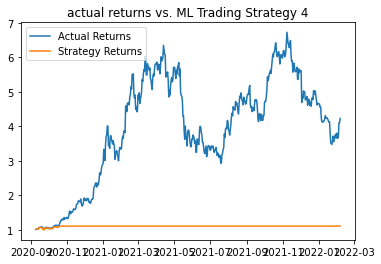

In [89]:
# Plot the actual returns versus the strategy returns
(1 + btc4_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
    title = 'actual returns vs. ML Trading Strategy 4'
)

In [90]:
# Calculate the cumulative returns of the ML Trading Strategy 4
xgb_returns = (1 + btc4_predictions_df["Strategy Returns"]).cumprod()

# Review the Results
xgb_returns[-1]

1.1078857942036389

In [91]:
# Use the describe function to calulate the daily standard deviation
btc4_predictions_df["Strategy Returns"].describe()['std']

0.004423390905151805

# Plot the Most Profitable Strategy and Display Entry Points

In [92]:
ema834_plot_df = btc_prices_ema834.copy()

In [93]:
ema834_plot_df["Signal"] = np.where(
    btc_prices_ema834["ema8"]> btc_prices_ema834["ema34"], 1.0, 0.0
)


In [94]:
ema834_plot_df["Entry/Exit"] = ema834_plot_df["Signal"].diff()
ema834_plot_df= ema834_plot_df.dropna()


In [95]:
exit =ema834_plot_df[ema834_plot_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    marker = "v",
    height=400)

# Visualize entry position relative to close price
entry = ema834_plot_df[ema834_plot_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    marker = "^",
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = ema834_plot_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize moving averages
moving_avgs = ema834_plot_df[['ema8', 'ema34']].hvplot(
    ylabel='Price in $',
    color= ['blue', 'salmon'],
    width=1000,
    height=400)

# Create the overlay plot
entry_exit_plot = security_close * moving_avgs * entry * exit

# Show the plot
entry_exit_plot.opts(
    title="Bitcoin - EMA8, EMA34, Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [index]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [index]   (value)
   .Scatter.Close.I  :Scatter   [index]   (close)
   .Scatter.Close.II :Scatter   [index]   (close)